In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
import seaborn
from os.path import join
%matplotlib inline

In [50]:
from PRmm.io import DmeDumpReader, TrcH5Reader
from PRmm.model import ReadersFixture

dmeDump = DmeDumpReader("/home/UNIXHOME/dalexander/Projects/SequelFrenzy/All4Mers-3150005-0026-bakeoff/T2B-longerBlocks-b4s4/dme-dump.h5")
traces = TrcH5Reader("/pbi/collections/315/3150005/r54004_20151201_015856/1_A01/m54004_151201_015904.trc.h5")
fx = ReadersFixture.fromIniFile(
    "/home/UNIXHOME/dalexander/Projects/SequelFrenzy/All4Mers-3150005-0026-bakeoff/fixture.ini",
    "T2B-longerBlocks")

In [47]:
def baselineSubtract(rawTrace, baseline, blockSize, baselineIsBackwards=False):
    """
    Calculate the baseline subtracted trace
    
    baselineIsBackwards=True is needed for old versions where the G,R channel order
    was reversed in the DME dump baseline output
    """
    if baselineIsBackwards:
        realBaseline = np.empty_like(baseline)
        realBaseline[:,0] = baseline[:,1]
        realBaseline[:,1] = baseline[:,0]
        baseline = realBaseline
    assert len(baseline) == len(blockSize)
    assert sum(blockSize)== rawTrace.shape[1]
    expandedBaseline = np.repeat(np.transpose(baseline), blockSize, axis=1)
    assert expandedBaseline.shape == rawTrace.shape
    return rawTrace - expandedBaseline

In [52]:
hn = badHn = 12910995

fxZmw = fx[hn]
dmeZmw = dmeDump.hole(hn)
trace = baselineSubtract(fxZmw.cameraTrace, dmeZmw.baseline, dmeZmw.blockSize, True)

In [93]:
from PRmm.model import Region
from PRmm.extras.ellipse import *

from intervaltree import IntervalTree, Interval
import math


def plot2C2AScatterTimeSeriesWithDme(fxZmw, dmeZmw):
    """
    Plot a 2C2A scatter plot for every `frameInterval` frames; overlay
    information about HQRegion and alignment(s), if found in the dataset.    
    """        
    t = baselineSubtract(fxZmw.cameraTrace, dmeZmw.baseline, dmeZmw.blockSize, True)        
    df = pd.DataFrame(np.transpose(t), columns=["C1", "C2"])

    # what is the extent of the data?  force a square perspective so
    # we don't distort the spectral angle
    xmin = ymin = min(df.min())
    xmax = ymax = max(df.max())

    def fracX(frac): return xmin + (xmax - xmin) * frac
    def fracY(frac): return ymin + (ymax - ymin) * frac

    #numPanes = int(math.ceil(float(zmwFixture.numFrames) / frameInterval))
    
    numPanes = np.sum(dmeZmw.blockSize > 0)
    numCols = 6
    numRows = int(math.ceil(float(numPanes) / numCols))
    paneSize = np.array([3, 3])

    figsize = np.array([numCols, numRows]) * paneSize
    fig, ax = plt.subplots(numRows, numCols, sharex=True, sharey=True,
                           figsize=figsize, dpi=200)
    axr = ax.ravel()

    details = "" # TODO
    fig.suptitle("%s\n%s" % (fxZmw.zmwName, details), fontsize=20)


    alnIntervals = IntervalTree()
    for r in fxZmw.regions:
        if r.regionType == Region.ALIGNMENT_REGION:
            alnIntervals.addi(r.startFrame, r.endFrame)

    def overlapsAln(frameStart, frameEnd):
        if alnIntervals.search(frameStart, frameEnd):
            return True
        else:
            return False

        
    nonemptyBlocks = np.flatnonzero(dmeZmw.blockSize > 0)
        
    for i in xrange(numPanes):
        j = nonemptyBlocks[i]
        frameSpan = startFrame, endFrame = dmeZmw.startFrame[j], dmeZmw.endFrame[j]
        axr[i].set_xlim(xmin, xmax)
        axr[i].set_ylim(ymin, ymax)
        axr[i].plot(df.C1[startFrame:endFrame], df.C2[startFrame:endFrame], ".", alpha=0.1)

        baseSpan = fxZmw.baseIntervalFromFrames(*frameSpan)
        axr[i].text(fracX(0.6), fracY(0.9), "/%d_%d" %  baseSpan)

        if overlapsAln(*frameSpan):
            axr[i].hlines(fracY(1.0), xmin, xmax, colors=["red"], linewidth=4)

            
        # Overlay ellipsoids    
        es = [ covarianceEllipse3(m, c3, 3.0)
               for (m, c3) in zip(dmeZmw.mean[j],
                                  dmeZmw.covariance[j]) ]
        for e in es:
            axr[i].add_artist(e)

    plt.subplots_adjust(top=0.97)
    return axr
    

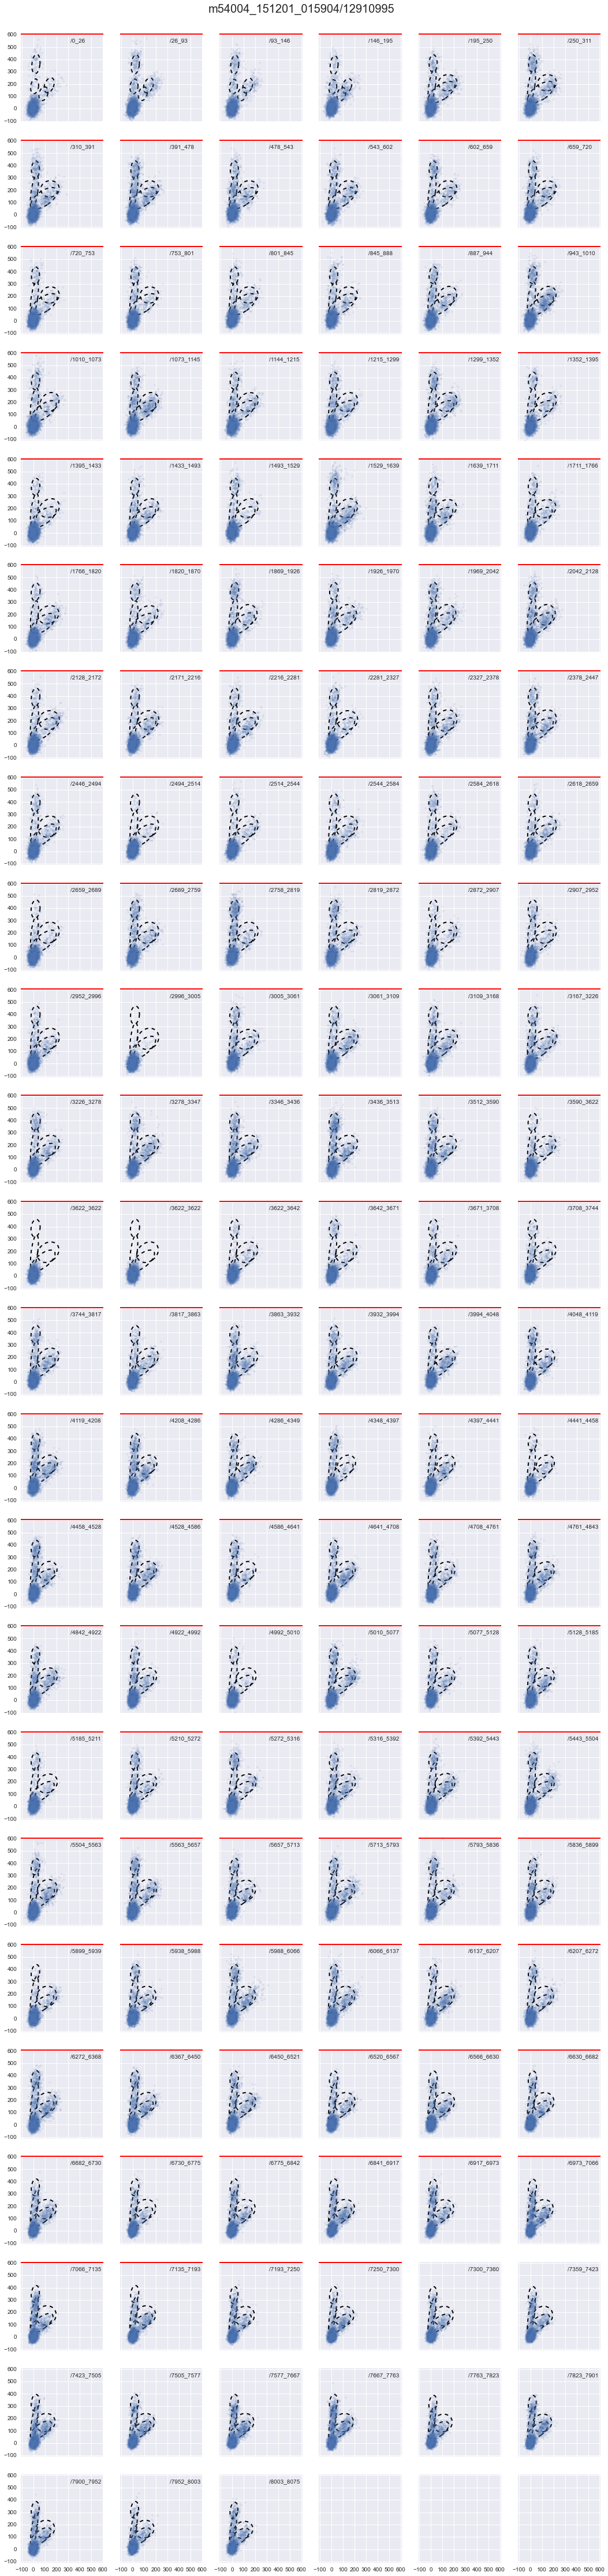

In [94]:
from PRmm.extras.clusterPlots import plot2C2AScatterTimeSeries

axr = plot2C2AScatterTimeSeriesWithDme(fxZmw, dmeZmw)